In [185]:
import pyspark
import pyspark.sql.functions as F
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.stat import Correlation

#### Requêtes SQL 

In [186]:
print(pyspark.__version__)

3.2.1


In [187]:
conf = pyspark.SparkConf().set("spark.jars.packages", 
                                "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1").setMaster("local").setAppName("My App").setAll([("spark.driver.memory", "40g"), ("spark;executor.memory", "50g")])

In [188]:
sc = SparkContext(conf=conf) #Connected to pyspark

In [189]:
sqlC = SQLContext(sc)

C:\Python\lib\site-packages\pyspark\sql\context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [190]:
mongo_ip = "mongodb://localhost:27017/restaurantsdb."

In [191]:
restaurants = sqlC.read.format("com.mongodb.spark.sql.DefaultSource").option("uri", mongo_ip + "restaurants").load()

In [192]:
restaurants.createOrReplaceTempView("restaurants")

In [193]:
restaurants = sqlC.sql("SELECT * FROM restaurants")

In [194]:
restaurants.show()

+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-------------+
|                 _id|             address|      borough|             cuisine|              grades|                name|restaurant_id|
+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-------------+
|{61f15a93e0cb0c13...|{1007, [-73.85607...|        Bronx|              Bakery|[{2014-03-03 01:0...|Morris Park Bake ...|     30075445|
|{61f15a93e0cb0c13...|{469, [-73.961704...|     Brooklyn|          Hamburgers|[{2014-12-30 01:0...|             Wendy'S|     30112340|
|{61f15a93e0cb0c13...|{351, [-73.985135...|    Manhattan|               Irish|[{2014-09-06 02:0...|Dj Reynolds Pub A...|     30191841|
|{61f15a93e0cb0c13...|{2780, [-73.98241...|     Brooklyn|           American |[{2014-06-10 02:0...|     Riviera Caterer|     40356018|
|{61f15a93e0cb0c13...|{97-22, [-73.8601...|       Queen

In [195]:
# Nombre de données dans la table
restaurants = sqlC.sql("SELECT COUNT(*) FROM restaurants")
restaurants.show()

+--------+
|count(1)|
+--------+
|    3772|
+--------+



In [196]:
# Nombre de restaurants par code postal
restaurants = sqlC.sql("SELECT address.zipcode, COUNT(restaurant_id) FROM restaurants GROUP BY address.zipcode")
restaurants.show()

+-------+--------------------+
|zipcode|count(restaurant_id)|
+-------+--------------------+
|  11205|                  10|
|  11236|                  11|
|  10309|                  13|
|  11106|                  27|
|  11218|                  16|
|  10452|                  11|
|  11428|                   5|
|  11237|                   9|
|  11379|                  11|
|  11364|                  10|
|  11249|                   8|
|  10012|                  94|
|  11001|                   2|
|  11385|                  34|
|  11238|                  12|
|  10039|                   4|
|  11427|                   5|
|  11367|                  10|
|  10010|                  27|
|  10038|                  18|
+-------+--------------------+
only showing top 20 rows



In [197]:
# Nombre de restaurants par type de cuisine
restaurants = sqlC.sql("SELECT cuisine, COUNT(restaurant_id) FROM restaurants GROUP BY cuisine")
restaurants.show()

+----------------+--------------------+
|         cuisine|count(restaurant_id)|
+----------------+--------------------+
|Pancakes/Waffles|                   7|
|Chinese/Japanese|                   1|
|         Mexican|                  73|
|   Jewish/Kosher|                  60|
|          Bakery|                 127|
|         Turkish|                  11|
|        Armenian|                   1|
|         Hotdogs|                   4|
|       Ethiopian|                   3|
|            Thai|                  14|
|          Indian|                  43|
|         Chinese|                 115|
|      Indonesian|                   2|
|       Soul Food|                   6|
|     Continental|                   8|
|           Steak|                  21|
|         African|                   4|
|CafÃ©/Coffee/Tea|                   1|
|          Donuts|                  43|
|           Tapas|                   4|
+----------------+--------------------+
only showing top 20 rows



In [198]:
# Le restaurant le mieux noté
from pyspark.sql.functions import *

restaurants = sqlC.sql("select *,aggregate(grades.score,0,(x,y) -> x + y) as sum from restaurants")
restaurants.show()

+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-------------+---+
|                 _id|             address|      borough|             cuisine|              grades|                name|restaurant_id|sum|
+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-------------+---+
|{61f15a93e0cb0c13...|{1007, [-73.85607...|        Bronx|              Bakery|[{2014-03-03 01:0...|Morris Park Bake ...|     30075445| 41|
|{61f15a93e0cb0c13...|{469, [-73.961704...|     Brooklyn|          Hamburgers|[{2014-12-30 01:0...|             Wendy'S|     30112340| 55|
|{61f15a93e0cb0c13...|{351, [-73.985135...|    Manhattan|               Irish|[{2014-09-06 02:0...|Dj Reynolds Pub A...|     30191841| 37|
|{61f15a93e0cb0c13...|{2780, [-73.98241...|     Brooklyn|           American |[{2014-06-10 02:0...|     Riviera Caterer|     40356018| 36|
|{61f15a93e0cb0c13...|{97-2

### Preprocessing

In [199]:
restaurants_df = sqlC.read.format("com.mongodb.spark.sql.DefaultSource").option("uri", mongo_ip + "restau_df").load()

In [200]:
restaurants_df.show()

+--------------------+--------------------+-----+-----------------+------------------+-------------+-------------+-------+
|                 _id|             cuisine|grade|        lattitude|         longitude|nb_infraction|     quartier|zipcode|
+--------------------+--------------------+-----+-----------------+------------------+-------------+-------------+-------+
|{61f15a93e0cb0c13...|              Bakery|    A|        40.848447|        -73.856077|            2|        Bronx|  10462|
|{61f15a93e0cb0c13...|          Hamburgers|    A|        40.662942|        -73.961704|            8|     Brooklyn|  11225|
|{61f15a93e0cb0c13...|               Irish|    A|       40.7676919|-73.98513559999999|            2|    Manhattan|  10019|
|{61f15a93e0cb0c13...|           American |    A|        40.579505|-73.98241999999999|            5|     Brooklyn|  11224|
|{61f15a93e0cb0c13...|       Jewish/Kosher|    Z|       40.7311739|       -73.8601152|           20|       Queens|  11374|
|{61f15a93e0cb0c

In [201]:
restaurants_df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- cuisine: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- lattitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- nb_infraction: integer (nullable = true)
 |-- quartier: string (nullable = true)
 |-- zipcode: string (nullable = true)



In [202]:
restaurants_df.describe().show()

+-------+--------------------+-----+------------------+------------------+------------------+-------------+-----------------+
|summary|             cuisine|grade|         lattitude|         longitude|     nb_infraction|     quartier|          zipcode|
+-------+--------------------+-----+------------------+------------------+------------------+-------------+-----------------+
|  count|                3772| 3772|              3772|              3772|              3772|         3772|             3772|
|   mean|                null| null| 40.67625120771491|-73.96846774331894|10.701219512195122|         null|10545.26802757158|
| stddev|                null| null|1.6256337301241979| 4.953221264543527|  5.98845956338147|         null| 588.991762883543|
|    min|              Afghan|    A|       -28.0168595|      -119.6368672|                -1|        Bronx|            10001|
|    max|Vietnamese/Cambod...|    Z|        51.6514664|       153.1628795|                89|Staten Island|           

In [203]:
import pymongo
import pandas as pd
from pymongo import MongoClient

#MongoDB collection to Pandas dataframe
c = MongoClient()
db = c.restaurantsdb
input_data = db.restau_df
df = pd.DataFrame(list(input_data.find()))
df

,_id,longitude,lattitude,zipcode,cuisine,quartier,nb_infraction,grade
0,61f15a93e0cb0c134b208f69,-73.856077,40.848447,10462,Bakery,Bronx,2,A
1,61f15a93e0cb0c134b208f6a,-73.961704,40.662942,11225,Hamburgers,Brooklyn,8,A
2,61f15a93e0cb0c134b208f6b,-73.985136,40.767692,10019,Irish,Manhattan,2,A
3,61f15a93e0cb0c134b208f6c,-73.982420,40.579505,11224,American,Brooklyn,5,A
4,61f15a93e0cb0c134b208f6d,-73.860115,40.731174,11374,Jewish/Kosher,Queens,20,Z
...,...,...,...,...,...,...,...,...
3767,61f15a94e0cb0c134b209e20,-73.986544,40.733770,10003,Café/Coffee/Tea,Manhattan,5,A
3768,61f15a94e0cb0c134b209e21,-73.946224,40.656571,11203,Café/Coffee/Tea,Brooklyn,3,A
3769,61f15a94e0cb0c134b209e22,-73.983944,40.756111,10036,Japanese,Manhattan,7,A
3770,61f15a94e0cb0c134b209e23,-73.986652,40.753641,10018,Sandwiches/Salads/Mixed Buffet,Manhattan,5,A


In [204]:
df['cuisine'].value_counts()

American            1255
Italian              325
Pizza                270
Café/Coffee/Tea      180
Hamburgers           159
                    ... 
CafÃ©/Coffee/Tea       1
Moroccan               1
Armenian               1
Chinese/Japanese       1
Salads                 1
Name: cuisine, Length: 70, dtype: int64

In [205]:
df['quartier'].value_counts()

Manhattan        1883
Queens            738
Brooklyn          684
Bronx             309
Staten Island     158
Name: quartier, dtype: int64

##### One Hot Encoding

In [206]:
from sklearn.preprocessing import LabelEncoder

df['cuisine'] = LabelEncoder().fit_transform(df['cuisine'])
df['quartier'] = LabelEncoder().fit_transform(df['quartier'])
df['grade'] = LabelEncoder().fit_transform(df['grade'])
df.head()

,_id,longitude,lattitude,zipcode,cuisine,quartier,nb_infraction,grade
0,61f15a93e0cb0c134b208f69,-73.856077,40.848447,10462,6,0,2,0
1,61f15a93e0cb0c134b208f6a,-73.961704,40.662942,11225,30,1,8,0
2,61f15a93e0cb0c134b208f6b,-73.985136,40.767692,10019,35,2,2,0
3,61f15a93e0cb0c134b208f6c,-73.982420,40.579505,11224,2,1,5,0
4,61f15a93e0cb0c134b208f6d,-73.860115,40.731174,11374,38,3,20,4


In [207]:
df["zipcode"] = df["zipcode"].astype(str).astype(int)
df.dtypes

_id               object
longitude        float64
lattitude        float64
zipcode            int32
cuisine            int32
quartier           int32
nb_infraction      int64
grade              int32
dtype: object

In [208]:
del df['_id']
del df['nb_infraction']
df.head()

,longitude,lattitude,zipcode,cuisine,quartier,grade
0,-73.856077,40.848447,10462,6,0,0
1,-73.961704,40.662942,11225,30,1,0
2,-73.985136,40.767692,10019,35,2,0
3,-73.982420,40.579505,11224,2,1,0
4,-73.860115,40.731174,11374,38,3,4


In [209]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [210]:
X.head()

,longitude,lattitude,zipcode,cuisine,quartier
0,-73.856077,40.848447,10462,6,0
1,-73.961704,40.662942,11225,30,1
2,-73.985136,40.767692,10019,35,2
3,-73.982420,40.579505,11224,2,1
4,-73.860115,40.731174,11374,38,3


In [211]:
y.head()

0    0
1    0
2    0
3    0
4    4
Name: grade, dtype: int32

##### Gradient Descent

In [212]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
data_train_df = (X_train, y_train)
data_test_df = (X_test, y_test)

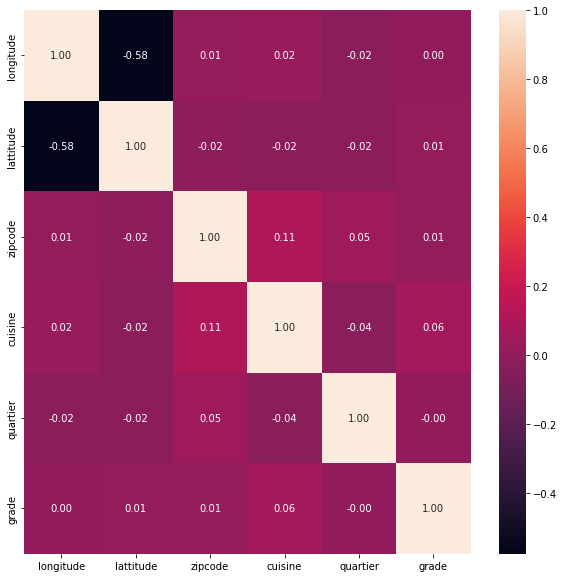

In [213]:
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

def plot_correlation(data):
    '''
    plot correlation's matrix to explore dependency between features 
    '''
    # init figure size
    rcParams['figure.figsize'] = 10, 10
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()
    fig.savefig('corr.png')

# plot correlation & densities
plot_correlation(df)

In [214]:
print("Nombre d'éléments dans la classe 0 : ", list(y_train).count(0))
print("Nombre d'éléments dans la classe 1 : ", list(y_train).count(1))
print("Nombre d'éléments dans la classe 2 : ", list(y_train).count(2))
print("Nombre d'éléments dans la classe 3 : ", list(y_train).count(3))

Nombre d'éléments dans la classe 0 :  1983
Nombre d'éléments dans la classe 1 :  149
Nombre d'éléments dans la classe 2 :  15
Nombre d'éléments dans la classe 3 :  0


In [215]:
# Oversample and plot imbalanced dataset with SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

# transform the dataset
oversample = SMOTE(sampling_strategy='not majority')
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train_balanced)
print(counter)

Counter({0: 1983, 1: 1983, 4: 1983, 2: 1983})


In [216]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=4)

# Train the model using the training sets
model.fit(X_train,y_train)

#Predict Output
predicted = model.predict(X_test)
print(predicted)

[4 0 0 ... 0 0 0]


In [217]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, predicted))

Accuracy: 0.873426110006627


- Quartier et Cuisine en catégorie
- Extraire grade et score
- Extraire longitude et latitude (variable adress)
- Split train set et test set
- Regression : transformer output en classe et comparer avec le modele de classification
- Choisir metrics de regression et classification
- Arbre de décision, Random Forest, Xgboost

Remarques : voir le nombre de controles par restaurant et le grade donné à chaque fois. 